In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from numba import jit

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *
plt.style.use('../peptidome.mplstyle')

from common import model_hierarchy
from lib.plotting import model_labels as labels

In [12]:
k = 9
#datasets = ['train', 'test', 'flat', 'independent', 'nskewfcov']
datasets = ['flat', 'nskewfcov']
sample_matrices = {}
for dataset in datasets:
    if dataset == 'flat':
        sample_matrices[dataset] =  load_matrix('data/%s_matrix_L9.csv.gz' % dataset)
    elif dataset in ['train', 'test']:
        sample_matrices[dataset] =  load_matrix('data/Human_%s_k9_matrix.csv.gz' % dataset)
    else:
        sample_matrices[dataset] =  load_matrix('data/Humanviruses_%s_k9_matrix.csv.gz' % dataset)

In [3]:
reference = set(matrix_to_kmers(sample_matrices['train'])) | set(matrix_to_kmers(sample_matrices['test']))

In [4]:
reference_all = set(count_kmers_proteome(human, k, clean=True))

In [5]:
len(reference), len(reference_all)

(10343050, 10401757)

In [39]:
def mat_to_dist(A, size=100000):
    sample = matrix_to_kmers(A[np.random.choice(A.shape[0], size=size, replace=False), :])
    ns = distance_distribution(sample, reference)
    return ns

In [40]:
ns_dict = {}
for model in datasets:
    print(model)
    ns_dict[model] = mat_to_dist(sample_matrices[model])
    print(np.sum(ns_dict[model]), ns_dict[model])

flat
100000 [    5   350 18693 80952]
nskewfcov
100000 [   76  2542 46302 51080]


In [41]:
ns_dict['empirical'] = mat_to_dist(load_matrix('data/Humanviruses_train_k9_matrix.csv.gz'))
ns_dict['empirical']

array([  167,  2878, 47244, 49711])

In [56]:
model_to_label = {'flat' : 'Null',
                  'nskewfcov' : 'Model',
                  'empirical' : 'Data'}

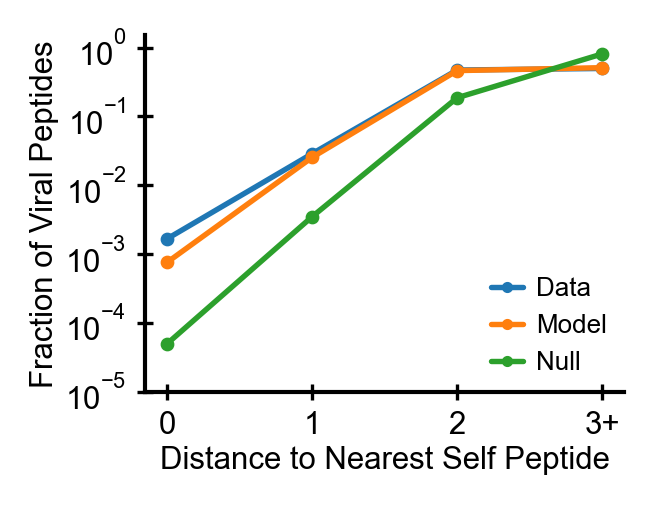

In [57]:
fig, ax = plt.subplots(figsize=(2.25, 1.75))
for model in ['empirical', 'nskewfcov', 'flat']:
    ns = ns_dict[model]
    ax.plot(range(4), ns/np.sum(ns), '-o', label=model_to_label[model])
ax.legend(loc='lower right')
ax.set_yscale('log')
ax.set_yticks(np.logspace(-5, 0, 6))
ax.set_ylim(1e-5, 1.5)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([0, 1, 2, '3+'])
ax.set_ylabel('Fraction of Viral Peptides')
ax.set_xlabel('Distance to Nearest Self Peptide')
fig.tight_layout()
fig.savefig('neighbors.svg')
fig.savefig(figuredir+'neighbors.svg')

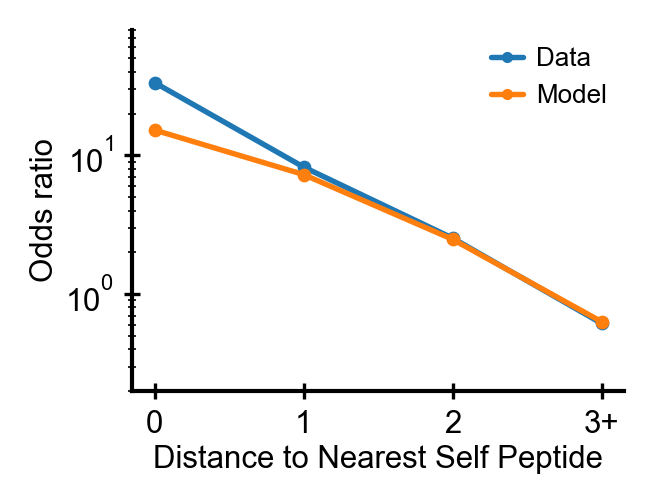

In [58]:
fig, ax = plt.subplots(figsize=(2.25, 1.75))
ns_flat = ns_dict['flat']
for model in ['empirical', 'nskewfcov']:
    ns = ns_dict[model]
    ax.plot(range(4), (ns/np.sum(ns))/(ns_flat/np.sum(ns_flat)), '-o', label=model_to_label[model])
ax.legend()
ax.set_yscale('log')
ax.set_ylim(0.2, 8e1)
ax.set_xticks([0, 1, 2, 3])
ax.set_xticklabels([0, 1, 2, '3+'])
ax.set_ylabel('Odds ratio')
ax.set_xlabel('Distance to Nearest Self Peptide')
fig.tight_layout()
fig.savefig(figuredir+'neighbors_normalized.svg')